<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



# Introduction

This notebooks presents basic **Deep Q-Network (DQN)** used to solve OpenAI Gym **Classic Control** environments like Mountain Car, Inverted Pendulum and so on. In this notebook we use DQN **without target network** for educational purposes.

# Imports

Imports (source file: [tiles3.py](tiles3.py), [helpers.py](helpers.py))

In [1]:
import os
import datetime
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

Import OpenAI Gym

In [2]:
import gym

Initialise TensorFlow

In [3]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

Import helpers for plotting

In [30]:
import helpers
import importlib
importlib.reload(helpers);

# Q-Learning

Epsilon random policy

In [5]:
def policy(st, model, eps):
    if np.random.rand() > eps:
        q_values = model.eval(np.stack([st]))
        return np.argmax(q_values)
    else:
        return env.action_space.sample()

Main training loop. Supports resuming from pre-trained agent.

In [6]:
def q_learning(env, frames, gamma, eps_decay_steps, eps_target,
               batch_size, model, mem, start_step=0,
               callback=None, trace=None, render=False):
    """Q-Learning, supprots resume
    
    Note: If resuming, all parameters should be identical to original call, with
        exception of 'start_step' and 'frames'.
    
    Params:
        env - environment
        frames - number of time steps to execute
        gamma - discount factor [0..1]
        eps_decay_steps - decay epsilon-greedy param over that many time steps
        eps_target - epsilon-greedy param after decay
        batch_size - neural network batch size from memory buffer
        model      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
        mem - memory reply buffer
        start_step - if continuning, pass in return value (tts_) here
        callback - optional callback to execute
        trace - this object handles data logging, plotting etc.
        render - render openai gym environment?
    """
    
    def eps_schedule(tts, eps_decay_steps, eps_target):
        if tts > eps_decay_steps:
            return eps_target
        else:
            eps_per_step_change = (1-eps_target) / eps_decay_steps
            return 1.0 - tts * eps_per_step_change
    
        
    assert len(mem) >= batch_size
    
    tts_ = start_step                        # total time step
    for _ in itertools.count():              # count from 0 to infinity
        
        S = env.reset()
        episode_reward = 0                   # purely for logging
        if render: env.render()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            eps = eps_schedule(tts_, eps_decay_steps, eps_target)
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            episode_reward += R
            if render: env.render()
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(tts_, t_, S, A, R, done, eps, episode_reward, model, mem, trace)
            
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = model.eval(n_states)
            targets = rewards + gamma * np.max(targets, axis=-1)
            targets[dones] = rewards[dones]  # return of next-to-terminal state is just R
            model.train(states, actions, targets)

            S = S_
            
            tts_ += 1
            if tts_ >= start_step + frames:
                return tts_                  # so we can pick up where we left
            
            if done:
                break

Stripped down version for evaluation. Does not train agent.

In [7]:
def evaluate(env, model, frames=None, episodes=None, eps=0.0, render=False):
    assert frames is not None or episodes is not None
        
    total_reward = 0
    
    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        if episodes is not None and e_ >= episodes:
            return total_reward
        
        S = env.reset()
        if render: env.render()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            total_reward += R
            if render: env.render()
    
            S = S_
            
            tts_ += 1
            if frames is not None and tts_ >= frames:
                return
            
            if done:
                break

Stripped down version to pre-fill memory buffer with random policy.

In [8]:
def mem_fill(env, mem, steps=None, episodes=None, render=False):
        
    # Fill memory buffer using random policy
    tts_ = 0
    for e_ in itertools.count():
        if episodes is not None and e_ >= episodes:
            return
        
        S = env.reset();
        if render: env.render()
        
        for t_ in itertools.count():
        
            A = env.action_space.sample()    # random policy
            S_, R, done, _ = env.step(A)
            if render: env.render()
                
            mem.append(S, A, R, S_, done)
            
            S = S_
            
            tts_ += 1
            if steps is not None and tts_ >= steps:
                return
            
            if done:
                break

# Function Approximators and Memory

In [25]:
class TFNeuralNet():
    def __init__(self, tf_session, tf_summary_writer,
                 nb_in, nb_hid_1, nb_hid_2, nb_out, lr):
        
        self._sess = tf_session
        self._summary_writer = tf_summary_writer
        
        self.nb_in = nb_in
        self.nb_hid_1 = nb_hid_1
        self.nb_hid_2 = nb_hid_2
        self.nb_out = nb_out
              
        self._x = tf.placeholder(name='xx', shape=[None, nb_in], dtype=tf.float32)
        self._y = tf.placeholder(name='yy', shape=[None, nb_out], dtype=tf.float32)

#         self._W_hid_1 = tf.get_variable('hid_1_W', shape=[nb_in, nb_hid_1], dtype=tf.float32)
#         self._b_hid_1 = tf.get_variable('hid_1_b', shape=[nb_hid_1], dtype=tf.float32,
#                                         initializer=tf.zeros_initializer())
#         self._z_hid_1 = tf.matmul(self._x, self._W_hid_1) + self._b_hid_1
#         self._h_hid_1 = tf.nn.relu(self._z_hid_1)
        self._h_hid_1 = tf.layers.dense(self._x, units=nb_hid_1,
                                        activation=tf.nn.relu, name='Hidden_1')

#         self._W_hid_2 = tf.get_variable('hid_2_W', shape=[nb_hid_1, nb_hid_2], dtype=tf.float32)
#         self._b_hid_2 = tf.get_variable('hid_2_b', shape=[nb_hid_2], dtype=tf.float32,
#                                        initializer=tf.zeros_initializer())
#         self._z_hid_2 = tf.matmul(self._h_hid_1, self._W_hid_2) + self._b_hid_2
#         self._h_hid_2 = tf.nn.relu(self._z_hid_2)
        self._h_hid_2 = tf.layers.dense(self._h_hid_1, units=nb_hid_2,
                                        activation=tf.nn.relu, name='Hidden_2')

#         self._W_out = tf.get_variable('out_W', shape=[nb_hid_2, nb_out], dtype=tf.float32)
#         self._b_out = tf.get_variable('out_b', shape=[nb_out],
#                                      initializer=tf.zeros_initializer())
#         self._y_hat = tf.matmul(self._h_hid_2, self._W_out) + self._b_out
        self._y_hat = tf.layers.dense(self._h_hid_2, units=nb_out,
                                      activation=None, name='Output')

        self._loss = tf.losses.mean_squared_error(self._y, self._y_hat)

        self._optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
        self._train_op = self._optimizer.minimize(self._loss)

        
    def backward(self, x, y):
        assert x.ndim == y.ndim == 2
        _, y_hat, loss = self._sess.run([self._train_op, self._y_hat, self._loss],
                                         feed_dict={self._x: x, self._y:y})
        return y_hat, loss
    
    def forward(self, x):
        return self._sess.run(self._y_hat, feed_dict={self._x: x})
    
    def save(self, filepath):
        saver = tf.train.Saver()
        saver.save(self._sess, filepath)
        
    def load(self, filepath):
        saver = tf.train.Saver()
        saver.restore(self._sess, filepath)

In [10]:
class TFFunctApprox():

    def __init__(self, model, st_low, st_high, rew_mean, rew_std, nb_actions):
        """Q-function approximator using Keras model

        Args:
            model: TFNeuralNet model
        """
        st_low = np.array(st_low);    st_high = np.array(st_high)
        self._model = model
        
        assert st_low.ndim == 1 and st_low.shape == st_high.shape
        
        if len(st_low) != model.nb_in:
            raise ValueError('Input shape does not match state_space shape')

        if nb_actions != model.nb_out:
            raise ValueError('Output shape does not match action_space shape')

        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)
        
        self._rew_mean = rew_mean
        self._rew_std = rew_std

    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        inputs = (states - self._offsets) * self._scales

        y_hat = self._model.forward(inputs)
        
        #return y_hat
        return y_hat*self._rew_std + self._rew_mean

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)
        
        
        targets = (targets-self._rew_mean) / self._rew_std    # normalise

        inputs = (states - self._offsets) * self._scales
        all_targets = self._model.forward(inputs)       # this should normalised already
        all_targets[np.arange(len(all_targets)), actions] = targets
        self._model.backward(inputs, all_targets)


In [11]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self.max_len = max_len                      # maximum length        
        self._curr_insert_ptr = 0                   # index to insert next data sample
        self._curr_len = 0                          # number of currently stored elements

        state_arr_shape = [max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self.max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                        # increment insertion pointer
        if self._curr_insert_ptr >= self.max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        
        indices = np.random.randint(        # randint much faster than np.random.sample
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices


    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be neg.
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    

---

# Experiment Setup

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [12]:
class WrapFrameSkip():
    def __init__(self, env, frameskip):
        assert frameskip >= 1
        self._env = env
        self._frameskip = frameskip
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        sum_rew = 0
        for _ in range(self._frameskip):
            obs, rew, done, info = self._env.step(action)
            sum_rew += rew
            if done: break
        return obs, sum_rew, done, info
    
    def render(self, mode='human'):
        return self._env.render(mode=mode)
        
    def close(self):
        self._env.close()               

In [13]:
class Trace():
    def __init__(self, tf_summary_writer, eval_every,
                 render=False, test_states=None, state_labels=None):
        if test_states is not None:
            assert test_states.ndim == 2
            
        self.tf_summary_writer = tf_summary_writer
        self.enable_plotting = False
        
        self.eval_every = eval_every
        self.test_states = test_states
        self.state_labels = state_labels
        
        self.tstep = 0
        self.total_tstep = 0
        
        self.q_values = collections.OrderedDict()
        self.ep_rewards = collections.defaultdict(float)
        self.last_ep_reward = None
        
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        self.epsilons = []

In [14]:
def callback(total_time_step, tstep, st, act, rew_, done_,
             eps, ep_reward, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
    assert total_time_step == trace.total_tstep
    
    trace.tstep = tstep
    
    trace.states.append(st)
    trace.actions.append(act)
    trace.rewards.append(rew_)
    trace.dones.append(done_)
    trace.epsilons.append(eps)
        
    if done_:
        trace.ep_rewards[total_time_step] = ep_reward
        trace.last_ep_reward = ep_reward
    
    
    #
    #   Summaries
    #
    if trace.tf_summary_writer is not None:
            
        # Epsilon
        summary = tf.Summary()
        summary.value.add(tag='Metrics/Epsilon', simple_value=eps)
        trace.tf_summary_writer.add_summary(summary, trace.total_tstep)

        # Average_Q
        if trace.eval_every is not None:
            if total_time_step % trace.eval_every == 0:
                q_test_values = model.eval(trace.test_states)
                q_test_average = np.mean(np.max(q_test_values, axis=-1))  # max over act.
                summary = tf.Summary()
                summary.value.add(tag='Metrics/Average_Q', simple_value=q_test_average)
                trace.tf_summary_writer.add_summary(summary, trace.total_tstep)

        # Ep_Reward
        if done_:
            summary = tf.Summary()
            summary.value.add(tag='Metrics/Ep_Reward', simple_value=ep_reward)
            trace.tf_summary_writer.add_summary(summary, trace.total_tstep)

            
    #
    #   Print, Evaluate, Plot
    #
        
    if (trace.eval_every is not None) and (trace.total_tstep % trace.eval_every == 0):
            
            print(f'wall: {datetime.datetime.now().strftime("%H:%M:%S")}   '
                  f'ep: {len(trace.ep_rewards):3}   tstep: {tstep:4}   '
                  f'total tstep: {trace.total_tstep:6}   '
                  f'eps: {eps:5.3f}   reward: {trace.last_ep_reward}   ')
            
            if len(st) == 2:
                # We are working with 2D environment,
                # eval. Q-Value function across whole state space
                q_arr = helpers.eval_state_action_space(model, env, split=[128,128])
                trace.q_values[trace.total_tstep] = q_arr
            else:
                # Environment is not 2D,
                # eval. on pre-defined random sample of states
                if trace.test_states is not None:
                    y_hat = model.eval(trace.test_states)
                    trace.q_values[trace.total_tstep] = y_hat
            
            if trace.enable_plotting:
                helpers.plot_all(env, model, memory, trace)
                print('■'*80)

    trace.total_tstep += 1

---

# Lunar Lander

In [ ]:
def experiment_lunarlander_tf(tf_logdir=None):
    
    tf.reset_default_graph()
    session = tf.Session()
    summary_writer = None
    if tf_logdir is not None:
        assert not os.path.exists(tf_logdir)
        summary_writer = tf.summary.FileWriter(tf_logdir)
        
    
    neural_net = TFNeuralNet(tf_session=session, tf_summary_writer=summary_writer,
                             nb_in=8, nb_hid_1=64, nb_hid_2=64, nb_out=4, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          st_low=np.array([-1., -1., -1., -1., -1., -1., -1., -1.]),
                          st_high=np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
                          rew_mean=0,
                          rew_std=1,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(8,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    
    trace = Trace(tf_summary_writer=summary_writer,
                  eval_every=1000,
                  test_states=np.array([[0, 1.4, 0, 0, 0, 0, 0, 0],     # init
                                        [0, 0.7, 0, 0, 0, 0, 0, 0],     # half way
                                        [0, 0.0, 0, 0, 0, 0, 0, 0],]),  # landing pad
                  state_labels=['Pos.x', 'Pos.y', 'Vel.x', 'Vel.y',
                                'Angle', 'Ang. Vel', 'Left Leg', 'Right Leg'])
    
    if summary_writer is not None:
        summary_writer.add_graph(session.graph)
        summary_writer.flush()
        session.run(tf.global_variables_initializer())
    
    return trace, model, mem

Setup the experiment

In [ ]:
env = gym.make('LunarLander-v2').env
env = WrapFrameSkip(env, frameskip=4)
trace, model, mem = experiment_lunarlander_tf(tf_logdir='tf_log/lunarlander/11')

Train the agent (can take 1h or more)

In [ ]:
tts = q_learning(env, frames=200000, gamma=.99,
                 eps_decay_steps=50000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace, render=False)

Save weights

In [ ]:
model._model.save('./tf_models/LunarLander-v2.ckpt')

Load weights

In [ ]:
model._model.load('./tf_models/LunarLander-v2.ckpt')

Enjoy trained agent

In [ ]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

# Acrobat Tensorflow

TODO: update to refactored code and re-run

In [ ]:
# def experiment_acrobot_tf(frames):
    
#     tf_model = TFNeuralNet(nb_in=6, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
#     model = TFFunctApprox(tf_model,
#                           env.observation_space.low,
#                           env.observation_space.high,
#                           rew_mean=-70,
#                           rew_std=10,
#                           nb_actions=env.action_space.n)
    
#     mem = Memory(max_len=100000, state_shape=(6,), state_dtype=float)
    
#     trace = Trace(eval_every=1000)
    
#     with tables.open_file('outarray.h5', mode='w') as f_:
#         model._model.setup_logdb(f_)
#         q_learning(env, frames=frames, gamma=.99, eps_decay_steps=20000, eps_target=0.1, action_repeat=4,
#                    batch_size=4096, model=model, mem=mem, callback=callback, trace=trace)
    
#     #test_car(env, ep=20, model=model, callback=callback, trace=trace)
#     print()
#     return trace, model, mem

In [ ]:
# env = gym.make('Acrobot-v1')
# trace_rl, model, mem = experiment_acrobot_tf(frames=25000)

In [ ]:
# enjoy_env(env, frames=500, eps=0.1, action_repeat=1, model=model, render=True, sleep=0.03)
# env.close()

# Cartpole

TODO: update to refactored code and re-run

In [ ]:
# def experiment_cartpole_tf(frames, tf_logdir=None):
    
#     # Note: This environment has peculiar dynamics where positive reward,
#     # along with non-corrected maximisation bias in Q-Function (we don't use Dual-DQN)
#     # causes runaway Q-Value effect where Q-Values increase continously
#     # This is ok for now, because RELATIVE Q-Values are still good enough
#     # I'm pretty sure using target network along with Dual-DQN is a correct proper fix for this
    
#     # CartPole original low/high values for observatios are not very reasonable, so we replace them:
#     # env.observation_space.low: [-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38]
    
#     tf.reset_default_graph()
#     session = tf.Session()
#     summary_writer = None
#     if tf_logdir is not None:
#         assert not os.path.exists(tf_logdir)
#         summary_writer = tf.summary.FileWriter(tf_logdir)
    
#     neural_net = TFNeuralNet(tf_session=session, tf_summary_writer=summary_writer,
#                              nb_in=4, nb_hid_1=64, nb_hid_2=64, nb_out=2, lr=0.00025)
    
#     model = TFFunctApprox(neural_net,
#                           st_low=np.array([-.2, -1.0, -0.15, -1.0]),
#                           st_high=np.array([.2, 1.0, 0.15, 1.0]),
#                           rew_mean=0,
#                           rew_std=1,
#                           nb_actions=env.action_space.n)
    
#     mem = Memory(max_len=100000, state_shape=(4,), state_dtype=float)
#     mem_fill(env, mem, steps=10000)
#     test_states, _, _, _, _, _ = mem.get_batch(10)
    
#     trace = Trace(tf_summary_writer=summary_writer,
#                   eval_every=1000,
#                   test_states=test_states)
    
#     if summary_writer is not None:
#         summary_writer.add_graph(session.graph)
#         summary_writer.flush()
#     session.run(tf.global_variables_initializer())
    
#     # with tables.open_file('outarray.h5', mode='w') as f_:
#     #     model._model.setup_logdb(f_)
    
#     return trace, model, mem

In [ ]:
# # Setup Experiment
# env = gym.make('CartPole-v0')
# trace, model, mem = experiment_cartpole_tf(frames=25000, tf_logdir='tf_log/cartpole/5')

In [ ]:
# tts = q_learning(env, frames=25000, gamma=.99, eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, callback=callback, trace=trace, render=False)

In [ ]:
# tts = q_learning(env, frames=10000, gamma=.99, eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace, render=False)

In [ ]:
# evaluate(env, model, frames=2000, render=True)
# env.close()

# MountainCar - 222

In [26]:
def experiment_mountaincar_tf(tf_logdir=None):
    
    tf.reset_default_graph()
    session = tf.Session()
    summary_writer = None
    if tf_logdir is not None:
        assert not os.path.exists(tf_logdir)
        summary_writer = tf.summary.FileWriter(tf_logdir)
    
    neural_net = TFNeuralNet(tf_session=session, tf_summary_writer=summary_writer,
                             nb_in=2, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-50,
                          rew_std=15,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(tf_summary_writer=summary_writer,
                  eval_every=1000,
                  test_states=test_states)
    
    if summary_writer is not None:
        summary_writer.add_graph(session.graph)
        summary_writer.flush()
    session.run(tf.global_variables_initializer())
    
    # with tables.open_file('outarray.h5', mode='w') as f_:
    #     model._model.setup_logdb(f_)
    
    return trace, model, mem

Setup the experiment

In [27]:
env = gym.make('MountainCar-v0').env
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_mountaincar_tf()
# trace.enable_plotting = True

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Train the agent

In [28]:
tts = q_learning(env, frames=15000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 07:27:35   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 07:27:39   ep:   1   tstep:  108   total tstep:   1000   eps: 0.955   reward: -1783.0   
wall: 07:27:44   ep:   1   tstep: 1108   total tstep:   2000   eps: 0.910   reward: -1783.0   
wall: 07:27:49   ep:   3   tstep:    0   total tstep:   3000   eps: 0.865   reward: -617.0   
wall: 07:27:55   ep:   4   tstep:  308   total tstep:   4000   eps: 0.820   reward: -1384.0   
wall: 07:28:00   ep:   7   tstep:   33   total tstep:   5000   eps: 0.775   reward: -543.0   
wall: 07:28:05   ep:  10   tstep:   81   total tstep:   6000   eps: 0.730   reward: -760.0   
wall: 07:28:10   ep:  16   tstep:   34   total tstep:   7000   eps: 0.685   reward: -371.0   
wall: 07:28:16   ep:  22   tstep:   24   total tstep:   8000   eps: 0.640   reward: -318.0   
wall: 07:28:21   ep:  27   tstep:   85   total tstep:   9000   eps: 0.595   reward: -207.0   
wall: 07:28:27   ep:  34   tstep:  155   total tstep:  1000

Optional: train some more

In [17]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

wall: 07:15:46   ep:  89   tstep:   90   total tstep:  15000   eps: 0.325   reward: -161.0   


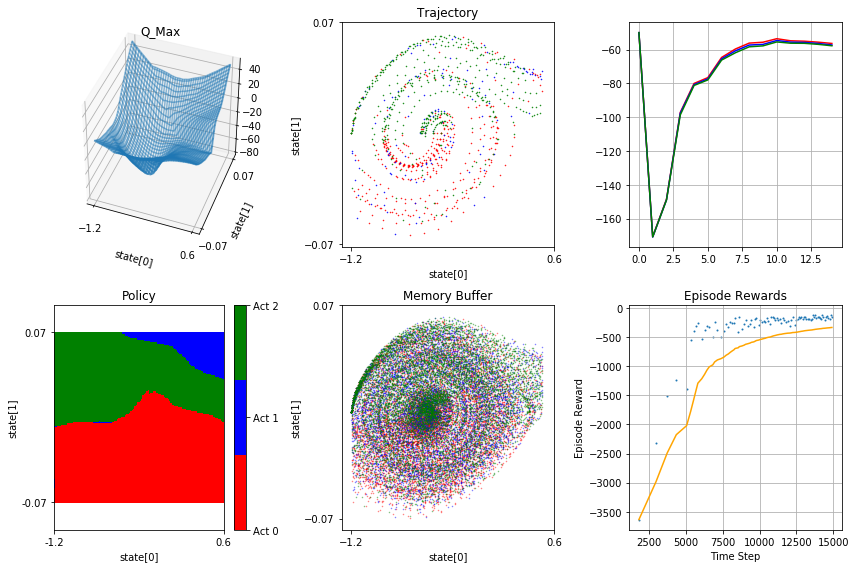

In [21]:
helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [27]:
model._model.save('./tf_models/MountainCar.ckpt')

Load weights

In [28]:
model._model.load('./tf_models/MountainCar.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/MountainCar.ckpt


Enjoy trained agent

In [29]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

# MountainCar

In [14]:
def experiment_mountaincar_tf(tf_logdir=None):
    
    tf.reset_default_graph()
    session = tf.Session()
    summary_writer = None
    if tf_logdir is not None:
        assert not os.path.exists(tf_logdir)
        summary_writer = tf.summary.FileWriter(tf_logdir)
    
    neural_net = TFNeuralNet(tf_session=session, tf_summary_writer=summary_writer,
                             nb_in=2, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-50,
                          rew_std=15,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(tf_summary_writer=summary_writer,
                  eval_every=1000,
                  test_states=test_states)
    
    if summary_writer is not None:
        summary_writer.add_graph(session.graph)
        summary_writer.flush()
    session.run(tf.global_variables_initializer())
    
    # with tables.open_file('outarray.h5', mode='w') as f_:
    #     model._model.setup_logdb(f_)
    
    return trace, model, mem

Setup the experiment

In [15]:
env = gym.make('MountainCar-v0').env
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_mountaincar_tf()
# trace.enable_plotting = True

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Train the agent

In [16]:
tts = q_learning(env, frames=15000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 16:35:53   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 16:36:09   ep:   0   tstep: 1000   total tstep:   1000   eps: 0.955   reward: None   
wall: 16:36:25   ep:   1   tstep:  179   total tstep:   2000   eps: 0.910   reward: -3642.0   
wall: 16:36:40   ep:   1   tstep: 1179   total tstep:   3000   eps: 0.865   reward: -3642.0   
wall: 16:36:56   ep:   4   tstep:  343   total tstep:   4000   eps: 0.820   reward: -467.0   
wall: 16:37:12   ep:   7   tstep:  221   total tstep:   5000   eps: 0.775   reward: -615.0   
wall: 16:37:28   ep:  12   tstep:   74   total tstep:   6000   eps: 0.730   reward: -555.0   
wall: 16:37:45   ep:  17   tstep:   55   total tstep:   7000   eps: 0.685   reward: -296.0   
wall: 16:38:01   ep:  23   tstep:  147   total tstep:   8000   eps: 0.640   reward: -436.0   
wall: 16:38:18   ep:  30   tstep:  145   total tstep:   9000   eps: 0.595   reward: -322.0   
wall: 16:38:35   ep:  39   tstep:   63   total tstep:  10000  

Optional: train some more

In [17]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

wall: 07:30:20   ep:  84   tstep:   56   total tstep:  15000   eps: 0.325   reward: -191.0   


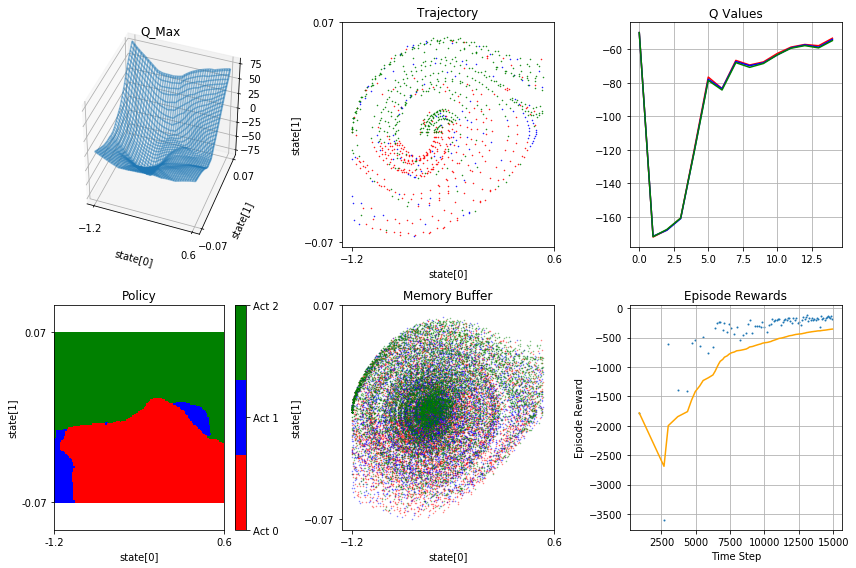

In [31]:
helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [27]:
model._model.save('./tf_models/MountainCar.ckpt')

Load weights

In [28]:
model._model.load('./tf_models/MountainCar.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/MountainCar.ckpt


Enjoy trained agent

In [29]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 15000 iterations

<img src="assets/mountaincar.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```
wall: 16:45:30   ep:  91   tstep:   22   total tstep:  15000   eps: 0.325   reward: -134.0
```

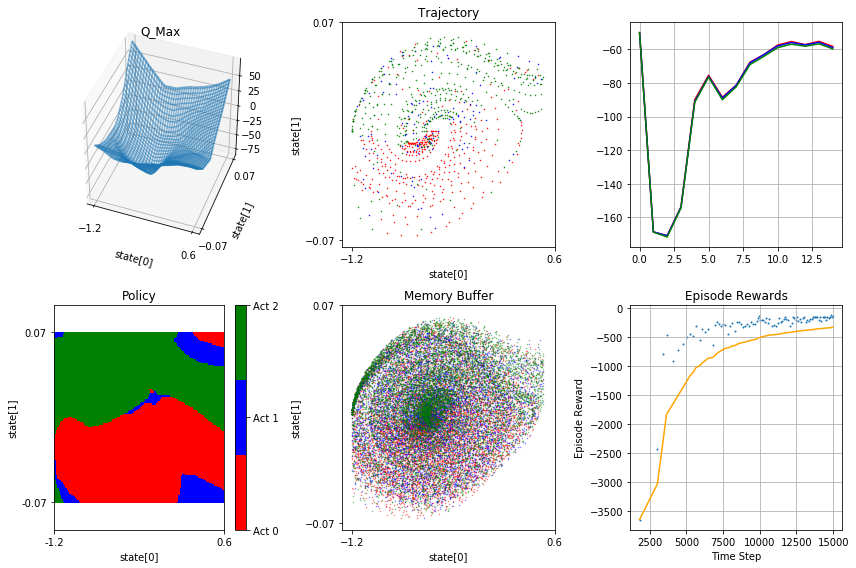

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Pendulum

Discretised version of Pendulum-v0 environment. State space is reduced to 2d as well (angle, velocity) from original 3d (cos, sin, vel) so we can plot whole state space on 3d wireframe plot

TODO: update to refactored code and re-run

In [ ]:
# class Pendulum2DEnv():
#     def __init__(self):
#         self._env = gym.make('Pendulum-v0')
#         self.observation_space = BoxSpace(
#             shape=(2,), low=[-np.pi, -8.0], high=[np.pi, 8.0]
#         )
#         self.action_space = DiscreteSpace(n=3)
        
#     def reset(self):
#         cos, sin, vel = self._env.reset()
#         theta = np.arctan2(sin, cos)
#         return np.array([theta, vel])
        
#     def step(self, action):
#         torques = [-2.0, 0.0, 2.0]
#         # torques = [-2.0, -.5, 0.0, .5, 2.0]
#         joint_effort = torques[action]
        
#         obs, rew, done, _ = self._env.step([joint_effort])
#         cos, sin, vel = obs
#         theta = np.arctan2(sin, cos)
#         return np.array([theta, vel]), rew, done, obs
    
#     def render(self):
#         self._env.render()
        
#     def close(self):
#         self._env.close()

In [ ]:
# def experiment_pendulum_tf(frames):
    
#     tf_model = TFNeuralNet(nb_in=2, nb_hid_1=64, nb_hid_2=64, nb_out=3)
#     model = TFFunctApprox(tf_model,
#                           env.observation_space.low,
#                           env.observation_space.high,
#                           rew_mean=-210,
#                           rew_std=50,
#                           nb_actions=env.action_space.n)
    
#     mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    
#     trace = Trace(eval_every=1000)
    
#     with tables.open_file('outarray.h5', mode='w') as f_:
#         model._model.setup_logdb(f_)
#         q_learning(env, frames=frames, gamma=.99, eps_decay_steps=20000, eps_target=0.1, action_repeat=1,
#                    batch_size=4096, model=model, mem=mem, callback=callback, trace=trace)
    
#     #test_car(env, ep=20, model=model, callback=callback, trace=trace)
#     print()
#     return trace

In [ ]:
# env = Pendulum2DEnv()
# trace_rl = experiment_pendulum_tf(frames=25000)

In [50]:
model._model.load('./tf_models/MountainCar.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/MountainCar.ckpt


# Test Render

In [46]:
import time

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [55]:
def frames_render(env, frames, episodes, eps, model, callback=None, trace=None, render=True, sleep=0):

    rendered_frames = []
    
    def policy(st, model, eps):
        if np.random.rand() > eps:
            stack = np.stack([st])  # convert lazyframe to nn input shape [1, 84, 84, 4]
            q_values = model.eval(stack)
            return np.argmax(q_values)
        else:
            return env.action_space.sample()
        
    total_reward = 0
    
    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        
        S = env.reset()
        
        if render:
            rendered_frames.append(env.render(mode='rgb_array'))
            #env.render()
            time.sleep(sleep)
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            # print(e_, t_)
            
            A = policy(S, model, eps)
            
            S_, R, done, info = env.step(A)
            
            #total_reward += info['full-reward']
            
            if render:
                rendered_frames.append(env.render(mode='rgb_array'))
                #env.render()
                time.sleep(sleep)
            
            if callback is not None:
                callback(tts_, e_, t_, S, A, R, done, eps, model, None, trace)
    
            if done:
                break
                
            if frames is not None and tts_ >= frames:
                return rendered_frames, total_reward
                
            S = S_
                
            tts_ += 1
            
        if episodes is not None and e_ >= episodes-1:
            return rendered_frames, total_reward

In [51]:
env.close()

In [52]:
evaluate(env, frames=None, episodes=1, eps=0.05, model=model, render=True)

-151.0

In [56]:
rendered_frames, total_reward = frames_render(env, frames=None, episodes=1, eps=0.05, model=model, render=True)
print(total_reward)

0


In [58]:
rendered_frames[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [89]:
plt.ioff()

fig = plt.figure(figsize=(rendered_frames[0].shape[1] / 72.0, rendered_frames[0].shape[0] / 72.0), dpi = 72)
ax = fig.add_subplot(111);

patch = ax.imshow(rendered_frames[0])

plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False)

In [90]:
def animate(i):
    patch.set_data(rendered_frames[i])

In [91]:
anim = animation.FuncAnimation(fig, animate, frames=len(rendered_frames), interval=20, repeat=True)


In [92]:
HTML(anim.to_html5_video())

In [95]:
env = gym.make('MountainCar-v0').env
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_mountaincar_tf()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Train the agent

In [ ]:
trace.enable_plotting = False
tts = q_learning(env, frames=15000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

In [98]:
trace.states[-1]

array([-0.70570725, -0.04455966])

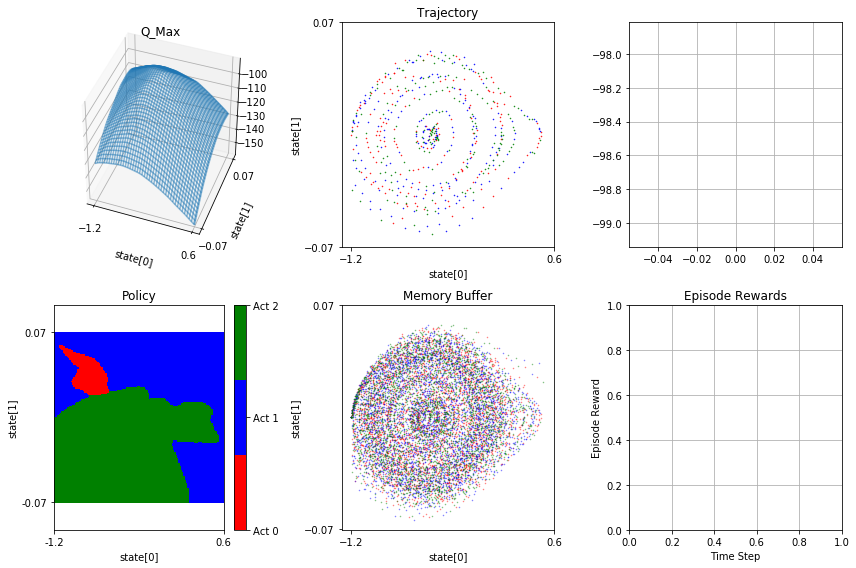

In [102]:
plot_all(trace, model, env, mem)